In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Loading all of that takes a lot of RAM, comment out what you don't need
# Also replace relative paths with your own paths to datasets
train_history_path = f"data/large/train/history.parquet"
test_history_path = f"data/testset/test/history.parquet"
train_behaviours_path = f"data/large/train/behaviors.parquet"
test_behaviours_path = f"data/testset/test/behaviors.parquet"
train_articles_path = f"data/large/articles.parquet"
test_artilces_path = f"data/testset/articles.parquet"

train_articles = pd.read_parquet(train_articles_path)
test_articles = pd.read_parquet(test_artilces_path)
train_history = pd.read_parquet(train_history_path)
train_behaviours = pd.read_parquet(train_behaviours_path)
test_history = pd.read_parquet(test_history_path)
test_behaviours = pd.read_parquet(test_behaviours_path)

In [ ]:
# ARTICLES ANALYSIS BELOW

In [11]:
cols = ["total_inviews", "total_pageviews", "total_read_time"]
print("Articles NaN info; rest of columns have no NaNs")
# Print NaN info for relevant columns in articles
for set, data in zip(["Train", "Test"], [train_articles, test_articles]):
    print(f"\n{set} set NaN info:\n")
    print(f"{'col':<25} | {'count':<10} | {'count Nan':<10} | {'% of NaN':<10}")
    print("-------------------------------------------------------------")
    for col in cols:
        if col not in data.columns:
            continue
        count = len(data[col])
        nan_count = data[col].isna().sum()
        nan_perc = nan_count / len(data) * 100
        print(f"{col:<25} | {count:<10} | {nan_count:<10} | {nan_perc:<10.2f}")

Articles NaN info; rest of columns have no NaNs

Train set NaN info:

col                       | count      | count Nan  | % of NaN  
-------------------------------------------------------------
total_inviews             | 125541     | 107205     | 85.39     
total_pageviews           | 125541     | 108600     | 86.51     
total_read_time           | 125541     | 108600     | 86.51     

Test set NaN info:

col                       | count      | count Nan  | % of NaN  
-------------------------------------------------------------
total_inviews             | 125541     | 107205     | 85.39     
total_pageviews           | 125541     | 108600     | 86.51     
total_read_time           | 125541     | 108600     | 86.51     


In [ ]:
# USER HISTORY ANALYSIS BELOW

In [2]:
history_times = np.concatenate(train_history.impression_time_fixed)
behaviour_times = train_behaviours.impression_time.to_numpy()
history_delta = history_times.max() - history_times.min()
behaviour_delta = behaviour_times.max() - behaviour_times.min()

print(f"User histories span: {np.timedelta64(history_delta, 'D')}")
print(f"Behaviours span: {np.timedelta64(behaviour_delta, 'D')}")

User histories span: 20 days
Behaviours span: 6 days


Statistics for length of user history:

set        | count      | mean       | std        | min        | max       
-----------------------------------------------------------------------
test       | 807677     | 144.64     | 163.69     | 5.0        | 1530.0    
train      | 788090     | 158.84     | 178.25     | 5.0        | 2696.0    


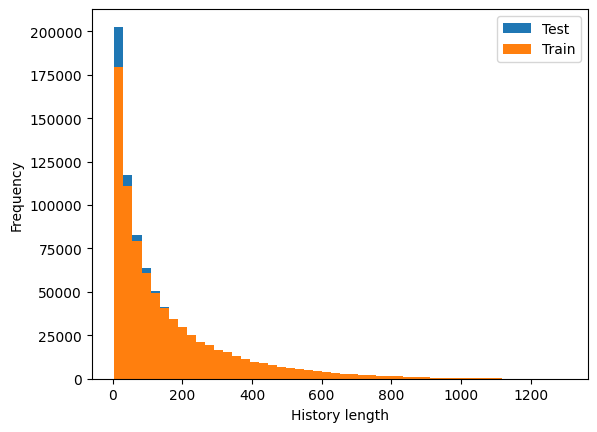

In [2]:
print("Statistics for length of user history:\n")
print(f"{'set':<10} | {'count':<10} | {'mean':<10} | {'std':<10} | {'min':<10} | {'max':<10}")
print("-----------------------------------------------------------------------")
for set, data in zip(["test", "train"], [test_history, train_history]):
    history_lengths = data.article_id_fixed.transform(lambda x: x.size)
    stats = list(history_lengths.describe())
    plt.hist(history_lengths, bins=50, range=(5, 1300))
    print(f"{set:<10} | {int(stats[0]):<10} | {stats[1]:<10.2f} | {stats[2]:<10.2f} | {stats[3]:<10} | {stats[7]:<10}")
plt.xlabel("History length")
plt.ylabel("Frequency")
plt.legend(["Test", "Train"])

In [ ]:
# BEHAVIOUR ANALYSIS BELOW

In [4]:
# Check which impressions/sessions/users from test are in train
cols = ["impression_id", "session_id", "user_id"]
print("IDs from behaviour data that are in both test and train sets:\n")
print(f"{'column name':<15} | {'n in train':<10} | {'% in train':<6}")
print("------------------------------------------")
for col in cols:
    train_session_ids = train_behaviours[col]
    in_train_sess = test_behaviours[col].isin(train_session_ids).sum()
    in_train_percentage = in_train_sess / len(test_behaviours) * 100
    print(f"{col:<15} | {in_train_sess:<10} | {in_train_percentage:<6.2f}%")

IDs from behaviour data that are in both test and train sets:

column name     | n in train | % in train
------------------------------------------
impression_id   | 0          | 0.00  %
session_id      | 977165     | 7.22  %
user_id         | 10461086   | 77.28 %



Session length statistics:

set        | count      | mean       | std        | min        | max       
---------------------------------------------------------------------
test       | 6566533    | 2.06       | 78.07      | 1.0        | 200000.0  
train      | 6227464    | 1.94       | 1.53       | 1.0        | 66.0      


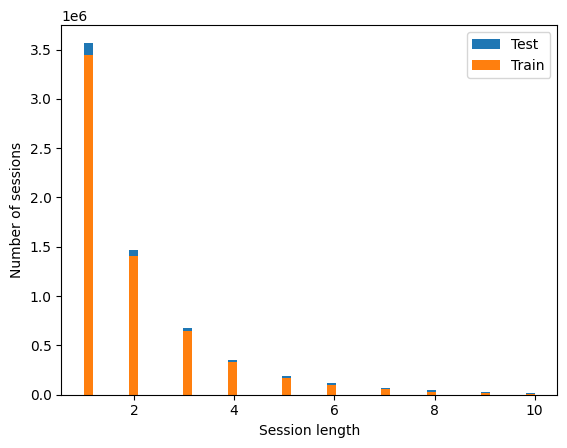

In [8]:
# Calculate session lengths statistics and plot histograms
print("\nSession length statistics:\n")
print(f"{'set':<10} | {'count':<10} | {'mean':<10} | {'std':<10} | {'min':<10} | {'max':<10}")
print("---------------------------------------------------------------------")
for name, data in zip(["test", "train"], [test_behaviours, train_behaviours]):
    session_lengths = data.groupby("session_id").size()
    stats = list(session_lengths.describe())
    plt.hist(session_lengths, bins=50, range=(1, 10))
    print(f"{name:<10} | {int(stats[0]):<10} | {stats[1]:<10.2f} | {stats[2]:<10.2f} | {stats[3]:<10} | {stats[7]:<10}")
plt.xlabel("Session length")
plt.ylabel("Number of sessions")
plt.legend(["Test", "Train"])

Predicted clicks lengths statistics:

count      | mean       | std        | min        | max       
---------------------------------------------------------
12063890   | 1.01       | 0.09       | 1.0        | 10.0      

Percentage of single click sessions: 99.50%


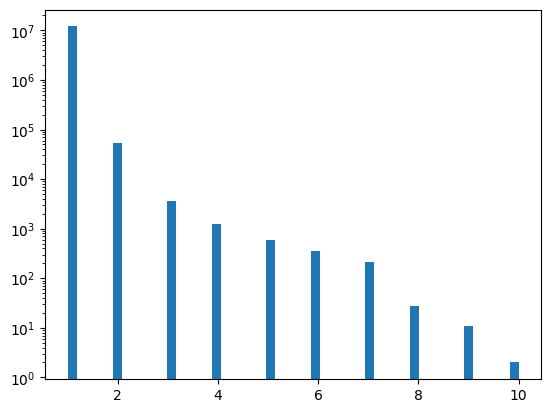

In [19]:
print("Predicted clicks lengths statistics:\n")
print(f"{'count':<10} | {'mean':<10} | {'std':<10} | {'min':<10} | {'max':<10}")
print("---------------------------------------------------------")
predict_lengths = train_behaviours.article_ids_clicked.apply(lambda x: len(x))
stats = list(predict_lengths.describe())
plt.hist(predict_lengths, bins=50, range=(1, 10))
plt.yscale("log")
print(f"{int(stats[0]):<10} | {stats[1]:<10.2f} | {stats[2]:<10.2f} | {stats[3]:<10} | {stats[7]:<10}")

len1_percent = predict_lengths[predict_lengths == 1].count() / len(predict_lengths) * 100
print(f"\nPercentage of single click sessions: {len1_percent:.2f}%")

In [13]:
cols = ["scroll_percentage", "gender", "postcode", "age", "next_read_time", "next_scroll_percentage"]
# Print NaN info for relevant columns in behaviours data
print("Behaviours NaN info; rest of columns have no NaNs")
for set, data in zip(["Train", "Test"], [train_behaviours, test_behaviours]):
    print(f"\n{set} set NaN info:\n")
    print(f"{'col':<25} | {'count':<10} | {'count Nan':<10} | {'% of NaN':<10}")
    print("-------------------------------------------------------------")
    for col in cols:
        if col not in data.columns:
            continue
        count = len(data[col])
        nan_count = data[col].isna().sum()
        nan_perc = nan_count / len(data) * 100
        print(f"{col:<25} | {count:<10} | {nan_count:<10} | {nan_perc:<10.2f}")

Behaviours NaN info; rest of columns have no NaNs

Train set NaN info:

col                       | count      | count Nan  | % of NaN  
-------------------------------------------------------------
scroll_percentage         | 12063890   | 8523902    | 70.66     
gender                    | 12063890   | 11176907   | 92.65     
postcode                  | 12063890   | 11795148   | 97.77     
age                       | 12063890   | 11694243   | 96.94     
next_read_time            | 12063890   | 319928     | 2.65      
next_scroll_percentage    | 12063890   | 1360982    | 11.28     

Test set NaN info:

col                       | count      | count Nan  | % of NaN  
-------------------------------------------------------------
scroll_percentage         | 13536710   | 9687485    | 71.56     
gender                    | 13536710   | 12579928   | 92.93     
postcode                  | 13536710   | 13246007   | 97.85     
age                       | 13536710   | 13139031   | 97.06     
